__[Link to presentation](https://drive.google.com/file/d/1vp2WHJsu1diMFWxMdvCK86S9kml1TVrL/view?usp=sharing)__

__[Link to analysis Dashboard](https://public.tableau.com/views/Productrangeanalysis_17029763841810/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)__

# Product Range Analysis

We have a dataset that contains the transaction history of an online store that sells household goods.

Project goal:

gaining a comprehensive understanding of the store's product range and its performance.

This includes assessing the popularity and profitability of individual products, identifying trends in customer preferences and determining which products contribute significantly to overall revenue.

##  Preparing data for analysis

In [1]:
# loading the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import warnings
warnings.filterwarnings('ignore')
!pip install sidetable
import sidetable as stb
!pip install -U textblob
import nltk
nltk.download('brown')
nltk.download('punkt')
from textblob import TextBlob
from collections import Counter
import scipy.stats as stats
from scipy.stats import f_oneway

     |████████████████████████████████| 636 kB 15.9 MB/s eta 0:00:01


[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# loading the dataset
df = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep = '\t')

In [3]:
# looking at the genral info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


In [4]:
# looking at the 1st 5 rows of the df
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


In [5]:
# converting dates to datetime data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%m/%d/%Y %H:%M")
#df.info()

### Handling missing values

In [6]:
# checking whether there are missing values
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000


1454 rows do not include item descriptions and 135080 - user IDs.

In [7]:
# looking at the number of unique values in each column
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
dtype: int64

We have 4372 unique customers, 25900 invoices and 4070 unique items in our stock, and it looks like somehow there are more product descriptions than items.

In [8]:
# checking the rows where we have missing values in Description column
df.query('Description != Description').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN


It looks like the rows where there are no product descriptions, also do not have unit prices and customer IDs.

In [9]:
# filtering rows that have no description and customer ID
no_desc_price_id = df.query('Description != Description and CustomerID != CustomerID')

In [10]:
# checking the amount of unique invoices
no_desc_price_id['InvoiceNo'].nunique()

1454

In [11]:
# checking how many of them are in the df
df['InvoiceNo'].isin(no_desc_price_id['InvoiceNo']).value_counts()

False    540455
True       1454
Name: InvoiceNo, dtype: int64

There are 1454 rows that are missing item descriptions, unit prices and customer IDs. Each of these invoices appear in the whole dataset only once, so it seems we can safely remove these rows, which make up 0.26 % of our data.

In [12]:
# removing the rows that are missing item descriptions, unit prices and customer IDs
df_new = df.drop(index=no_desc_price_id.index)

In [13]:
# counting how many invoices there are without customer IDs attached to them
df_new.query('CustomerID != CustomerID')['InvoiceNo'].nunique()

2256

There are 2256 invoices without customer IDs. It's worth checking whether any of these invoices always appear in the dataset without a customer ID.

In [14]:
# filtering rows that have no customer IDs
df_new.query('CustomerID != CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2018-11-29 14:32:00,2.51,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2018-11-29 14:32:00,2.51,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,2018-11-29 14:32:00,0.85,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2018-11-29 14:32:00,1.66,NaN
1447,536544,21790,VINTAGE SNAP CARDS,9,2018-11-29 14:32:00,1.66,NaN


In [15]:
# grouping df by invoice numbers and calculating the count of customer IDs associated with each invoice
# the size represents the total number of times an invoice was logged, 
# regardless of whether it had a customer ID (or with NaN)
id_count = df_new.groupby("InvoiceNo").agg({'CustomerID': ['count', 'size']})
id_count.columns = ['count', 'size']

In [16]:
id_count.head()

,count,size
InvoiceNo,,
536365,7,7
536366,2,2
536367,12,12
536368,4,4
536369,1,1


In [17]:
# looking at the invoices where customer ID count is smaller than the total number of times the invoice appeared in the dataset
id_count.query('count < size').head()

,count,size
InvoiceNo,,
536544,0,527
536555,0,2
536558,0,1
536565,0,2
536592,0,592


In [18]:
id_count.loc["536544"]

count      0
size     527
Name: 536544, dtype: int64

Invoice 536544 appears in the dataset 527 times, however, never with a customer ID.

In [19]:
# checking whether there are cases where the customer ID count is smaller than size, but bigger than 0
id_count.query('count < size and count > 0')

,count,size
InvoiceNo,,


It appears we won't be able to restore customer ID values in any of the 2256 invoices that lack customer ID.

In [20]:
# replacing missing customer IDs with 0
df_new['CustomerID'] = df_new['CustomerID'].fillna(0)

### Handling duplicates

In [21]:
# looking for duplicates
df_new.duplicated().sum()

5268

In [22]:
5268 / 541909 * 100

0.9721189350979592

Approx. 1% of our data consists of duplicates.

In [23]:
# iterating over all columns and looking at duplicates - how many unique options there are
for i in df_new[df_new.duplicated()].columns:
    print(i, df_new[df_new.duplicated()][i].nunique())

InvoiceNo 1933
StockCode 1706
Description 1732
Quantity 35
InvoiceDate 1914
UnitPrice 80
CustomerID 961


It appears duplicates appear across all columns.

In [24]:
# looking at the days duplicates show up
df_new[df_new.duplicated()]['InvoiceDate'].dt.date.unique()

array([datetime.date(2018, 11, 29), datetime.date(2018, 11, 30),
       datetime.date(2018, 12, 1), datetime.date(2018, 12, 3),
       datetime.date(2018, 12, 4), datetime.date(2018, 12, 5),
       datetime.date(2018, 12, 6), datetime.date(2018, 12, 7),
       datetime.date(2018, 12, 8), datetime.date(2018, 12, 10),
       datetime.date(2018, 12, 11), datetime.date(2018, 12, 12),
       datetime.date(2018, 12, 13), datetime.date(2018, 12, 14),
       datetime.date(2018, 12, 15), datetime.date(2018, 12, 17),
       datetime.date(2018, 12, 18), datetime.date(2018, 12, 19),
       datetime.date(2018, 12, 20), datetime.date(2018, 12, 21),
       datetime.date(2019, 1, 2), datetime.date(2019, 1, 3),
       datetime.date(2019, 1, 4), datetime.date(2019, 1, 7),
       datetime.date(2019, 1, 8), datetime.date(2019, 1, 9),
       datetime.date(2019, 1, 10), datetime.date(2019, 1, 11),
       datetime.date(2019, 1, 12), datetime.date(2019, 1, 14),
       datetime.date(2019, 1, 15), datetime.date

Duplicates have been recorded every month from Nov. 2018 until Dec. 2019.

In [25]:
# removing the duplicates
df_new = df_new.drop_duplicates().reset_index(drop = True)

In [26]:
# checking general info of the df after changes were made
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535187 entries, 0 to 535186
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   CustomerID   535187 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.6+ MB


### Data exploration

In [27]:
# checking statistics of each column
df_new.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,535187,24446,573585,1114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,535187,3958,85123A,2301,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,535187,4223,WHITE HANGING HEART T-LIGHT HOLDER,2357,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,535187.0,NaN,NaN,NaN,NaT,NaT,9.671593,219.059056,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,535187,22309,2019-10-29 14:41:00,1114,2018-11-29 08:26:00,2019-12-07 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,535187.0,NaN,NaN,NaN,NaT,NaT,4.645242,97.36481,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,535187.0,NaN,NaN,NaN,NaT,NaT,11466.973804,6778.037985,0.0,12348.0,14360.0,16242.0,18287.0


There seem to be unusual values in certain columns. For instance, in the quantity column, the lowest value is -80995, and the highest is 80995. Similarly, in the unit price column, the lowest price is -11062, and the highest is 38970.

In [28]:
# looking at the row with minus value in quantity column
df_new.query('Quantity == -80995.0')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
533707,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2019-12-07 09:27:00,2.08,16446.0


In [29]:
# checking rows with the item that was in previous query
df_new.query('StockCode == "23843"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
533706,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2019-12-07 09:15:00,2.08,16446.0
533707,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2019-12-07 09:27:00,2.08,16446.0


It looks like the customer placed a large order and then, soon after, it got cancelled.

In [30]:
# checking whether we have more invoice numbers that start with 'C'
df_new[df_new['InvoiceNo'].str.startswith('C')].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2018-11-29 09:49:00,4.65,15311.0
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2018-11-29 10:24:00,1.65,17548.0
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2018-11-29 10:24:00,0.29,17548.0


Among cancelled invoices appear to be also discounts.

In [31]:
# checking rows with Stock Code 'D'
df_new[df_new['StockCode']=='D'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
8844,C537164,D,Discount,-1,2018-12-03 13:21:00,29.29,14527.0
14180,C537597,D,Discount,-1,2018-12-05 12:34:00,281.00,15498.0
19020,C537857,D,Discount,-1,2018-12-06 16:00:00,267.12,17340.0
30580,C538897,D,Discount,-1,2018-12-13 09:14:00,5.76,16422.0


In [32]:
# looking at the total number of cancelled invoices
df_new[df_new['InvoiceNo'].str.startswith('C')]['InvoiceNo'].nunique()

3836

It appears there are 3836 cancelled / discount applied items in the dataset. We'll remove these rows as they are not relevant to our analysis.

In [33]:
# removing rows with cancelled items and discounts
df_new = df_new[~df_new['InvoiceNo'].str.startswith('C', na = False)]

In [34]:
# looking at the row with minus value in unit price column
df_new.query('UnitPrice == -11062.06')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
296537,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,0.0
296538,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,0.0


In [35]:
# checking the rows with same stock code as from the previous query
df_new.query('StockCode == "B"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
296536,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,0.0
296537,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,0.0
296538,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,0.0


There are entries of 'bad debt' that probably mean the amount won't be collected from a debtor.
At first the amount was positive which probably was added incorrectly and the following entries seem to be adjusted for the mistake by deducting the same amount.

We'll remove these rows too.

In [36]:
# removing the rows for which the invoice no starts with 'A'
df_new = df_new[~df_new['InvoiceNo'].str.startswith('A', na = False)]

In [37]:
# looking at statistics of unit price column
df_new.UnitPrice.describe()

count    525933.000000
mean          3.893671
std          32.674415
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

It looks like normally items are priced between 1.25 - 4.13.

In [38]:
# checking the highest unit price values
df_new.sort_values(by='UnitPrice', ascending = False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
14697,537632,AMAZONFEE,AMAZON FEE,1,2018-12-05 15:08:00,13541.33,0.0
171142,551697,POST,POSTAGE,1,2019-05-01 13:46:00,8142.75,16029.0
294289,562955,DOT,DOTCOM POSTAGE,1,2019-08-09 10:14:00,4505.17,0.0
264887,560373,M,Manual,1,2019-07-16 12:30:00,4287.63,0.0
417472,573077,M,Manual,1,2019-10-25 14:13:00,4161.06,12536.0


It looks like the store pays Amazon and postage fees and also sells Manuals.
We'll remove these items since they are not actual products that we're analyzing.

In [39]:
# checking rows with stock code 'D'
df_new.query('StockCode == "DOT"').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
1777,536544,DOT,DOTCOM POSTAGE,1,2018-11-29 14:32:00,569.77,0.0
2987,536592,DOT,DOTCOM POSTAGE,1,2018-11-29 17:06:00,607.49,0.0
5353,536862,DOT,DOTCOM POSTAGE,1,2018-12-01 11:13:00,254.43,0.0
5442,536864,DOT,DOTCOM POSTAGE,1,2018-12-01 11:27:00,121.06,0.0
5582,536865,DOT,DOTCOM POSTAGE,1,2018-12-01 11:28:00,498.47,0.0


In [40]:
# removing rows with stock codes: AMAZONFEE, DOT, POST and M/m
df_new = df_new[df_new['StockCode'].str.contains("AMAZONFEE|AMAZON|DOT|POST|M|m") == False]

In [41]:
# checking the lowest unit price values
df_new.sort_values(by='UnitPrice', ascending = True).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
311016,564645,82583,amazon,44,2019-08-24 13:38:00,0.0,0.0
515667,580377,84609,damages,-29,2019-11-30 17:52:00,0.0,0.0
515666,580376,22606,check,8,2019-11-30 17:49:00,0.0,0.0
274108,561103,85103,stock creditted wrongly,-32,2019-07-23 11:23:00,0.0,0.0
319813,565310,21829,?missing,-1897,2019-08-31 12:26:00,0.0,0.0


In addition, we have items with price 0.

In [42]:
# looking at item descriptions with unit price 0
df_new.query('UnitPrice == 0')['Description'].value_counts().head(20)

check                             159
?                                  47
damages                            45
damaged                            43
found                              24
sold as set on dotcom              20
adjustment                         16
Damaged                            14
thrown away                         9
Unsaleable, destroyed.              9
FRENCH BLUE METAL DOOR SIGN 1       9
Found                               8
FRENCH BLUE METAL DOOR SIGN 8       8
amazon                              8
FRENCH BLUE METAL DOOR SIGN 3       7
OWL DOORSTOP                        7
FRENCH BLUE METAL DOOR SIGN 4       7
Amazon                              7
FRENCH BLUE METAL DOOR SIGN No      7
??                                  7
Name: Description, dtype: int64

There are various items that are priced at 0. Mostly they appear to be faulty - damaged items, however, some look like regular items with price 0, which descriptions are in uppercase.

In [43]:
# looking closer at one of the items that cost 0
df_new.query('Description == "FRENCH BLUE METAL DOOR SIGN 1"').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
3333,536624,22676,FRENCH BLUE METAL DOOR SIGN 1,10,2018-11-30 10:45:00,1.25,13418.0
8778,537159,22676,FRENCH BLUE METAL DOOR SIGN 1,1,2018-12-03 13:17:00,1.25,14527.0
10702,537240,22676,FRENCH BLUE METAL DOOR SIGN 1,1,2018-12-04 10:08:00,2.51,0.0
14032,537534,22676,FRENCH BLUE METAL DOOR SIGN 1,3,2018-12-05 11:48:00,0.00,0.0
15090,537638,22676,FRENCH BLUE METAL DOOR SIGN 1,3,2018-12-05 15:28:00,2.51,0.0


Here we see that for this item the stock code is the same, but unit price varies and in one case it's been 0.

In [44]:
# querying rows where descriptions are in lowercase
lowercase = df_new[df_new['Description'].str.islower()]
lowercase.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
6282,536941,22734,amazon,20,2018-12-01 12:08:00,0.0,0.0
6283,536942,22139,amazon,15,2018-12-01 12:08:00,0.0,0.0
12917,537425,84968F,check,-20,2018-12-04 15:35:00,0.0,0.0
12918,537426,84968E,check,-35,2018-12-04 15:36:00,0.0,0.0
12962,537432,35833G,damages,-43,2018-12-04 16:10:00,0.0,0.0


In [45]:
# for the same rows, checking the description count
df_new[df_new['Description'].str.islower()]['Description'].value_counts().head(10)

check                    159
damages                   45
damaged                   43
found                     24
sold as set on dotcom     20
adjustment                16
thrown away                9
amazon                     8
dotcom                     6
ebay                       5
Name: Description, dtype: int64

There are 491 rows with lowercase item descriptions and majority of them appear to be faulty / damaged items. These won't be necessary for our further analysis, so these rows could be removed as well.

In [46]:
# df_new[~df_new['Description'].str.isupper()]
# df_new.drop(index=lowercase.index).reset_index(drop=True)
# # rows where stock code includes 'gift'
# df_new = df_new[df_new['StockCode'].str.contains("gift") == False].reset_index(drop=True)

In [47]:
# removing the lowercase rows
df_new = df_new[df_new['Description'].str.isupper()]
# rows where description includes: SAMPLES|PADS|AMAZON|?
df_new = df_new[df_new['Description'].str.contains(r"SAMPLES|PADS|AMAZON|\?+") == False].reset_index(drop=True)

In [48]:
#df_new = df_new[df_new['StockCode'].str.contains("gift") == False].reset_index(drop=True)

In [49]:
#df_new = df_new[df_new['Description'].str.contains(r"Amazon|Damaged|Found|Bank Charges|SAMPLES|Dotcom|AMAZON|\?+") == False].reset_index(drop=True)

In [50]:
# filtering out rows where quantity is higher than 0
df_new = df_new[df_new['Quantity'] > 0]

In [51]:
# converting customer ID to int data type
df_new['CustomerID'] = df_new['CustomerID'].astype('int64')

## Analyzing product range and purchase size

### Orders

In [52]:
# creating invoice year, month, week and date columns to aid in further analysis
df_new['InvYear']  = df_new['InvoiceDate'].dt.isocalendar().year
df_new['InvMonth'] = df_new['InvoiceDate'].dt.to_period('M').dt.start_time
df_new['InvWeek']  = df_new['InvoiceDate'].dt.to_period('W').dt.start_time
df_new['InvDay'] = df_new['InvoiceDate'].astype('datetime64[D]')

In [53]:
df_new.InvoiceDate.describe()

count                  521097
unique                  18322
top       2019-10-29 14:41:00
freq                     1107
first     2018-11-29 08:26:00
last      2019-12-07 12:50:00
Name: InvoiceDate, dtype: object

Our data covers only 2 days in November 2018 and a week of December 2019. We'll filter out these 2 incomplete months.

In [54]:
# filtering out days between dates
df_new = df_new.loc[df_new["InvDay"].between("2018-12-01", "2019-11-30")]

In [55]:
# grouping orders by month and checking the amount of unique invoices in each month
monthly_orders = df_new.groupby(df_new['InvMonth'])['InvoiceNo'].nunique().reset_index()
monthly_orders

,InvMonth,InvoiceNo
0,2018-12-01,1285
1,2019-01-01,1205
2,2019-02-01,1071
3,2019-03-01,1411
4,2019-04-01,1177
5,2019-05-01,1744
6,2019-06-01,1479
7,2019-07-01,1487
8,2019-08-01,1407
9,2019-09-01,1702


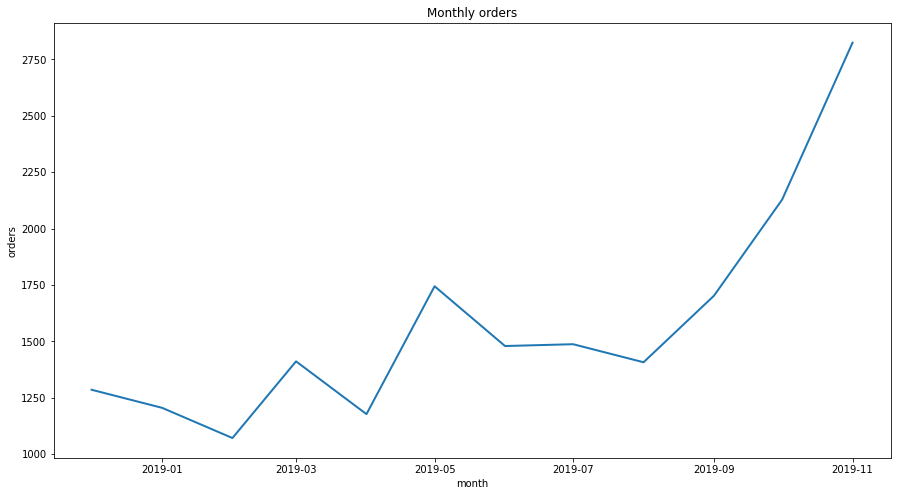

In [56]:
# plotting a line graph of monthly unique invoices made over time
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=monthly_orders, x="InvMonth", y="InvoiceNo", linewidth=2)
plt.title('Monthly orders')
plt.xlabel('month')
plt.ylabel('orders');

From December 2018 to April 2019, there are noticeable fluctuations in the number of orders, however, the most prominent observation is a significant spike in the number of orders in May 2019.

In the following months the invoice count is lower, but still higher than during the beginning of the year. Around September 2019 there's a noticeable spike again that lasts until the end of the year. Highest amount of orders have been made in October and November 2019 which might be due to the upcoming Holiday season and Black Friday.

In [57]:
# grouping df by customer ID and counting unique orders each customer had made
inv_count = df_new.groupby(df_new['CustomerID'])['InvoiceNo'].nunique()
# renaming series object
inv_count.name='InvCount'

In [58]:
# merging invoice count to the df
df_new = df_new.merge(inv_count, how='left',on=['CustomerID'])

In [59]:
# calculating items' - rows' total by multiplying unit price with quantity
# adding a new 'total' column
df_new['ItemTotal'] = df_new['Quantity']*df_new['UnitPrice']

In [60]:
# grouping df by invoice no and summing up the item total for the invoice
inv_total = df_new.groupby(df_new['InvoiceNo'])['ItemTotal'].sum()
inv_total.name='InvTotal'

In [61]:
# merging inv_total to df
df_new = df_new.merge(inv_total, how='left',on=['InvoiceNo'])

In [62]:
# looking at the 1st rows of the df
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvYear,InvMonth,InvWeek,InvDay,InvCount,ItemTotal,InvTotal
0,536847,22155,STAR DECORATION RUSTIC,48,2018-12-01 09:31:00,0.42,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,20.16,215.58
1,536847,21807,WHITE CHRISTMAS STAR DECORATION,36,2018-12-01 09:31:00,0.42,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.12,215.58
2,536847,22161,HEART DECORATION RUSTIC HANGING,24,2018-12-01 09:31:00,0.65,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.60,215.58
3,536847,22065,CHRISTMAS PUDDING TRINKET POT,24,2018-12-01 09:31:00,1.45,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,34.80,215.58
4,536847,20956,PORCELAIN T-LIGHT HOLDERS ASSORTED,12,2018-12-01 09:31:00,1.25,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.00,215.58


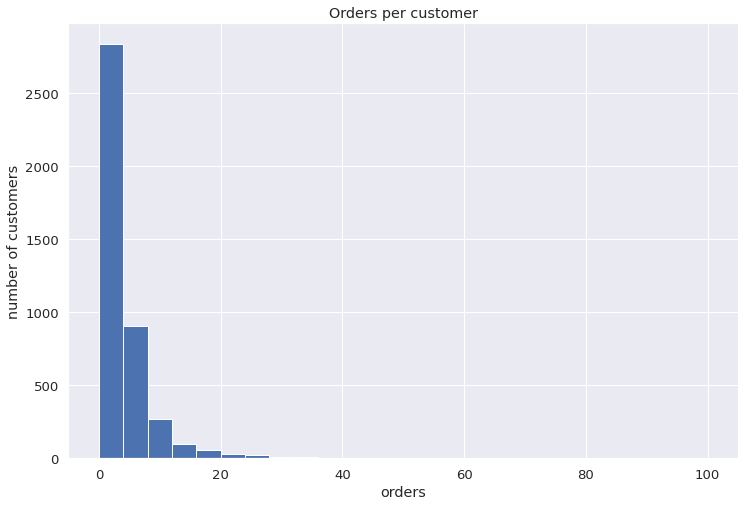

In [63]:
# plotting a histogram of number of orders per customer
sns.set(font_scale=1.2)
df_new.groupby(['CustomerID'])['InvoiceNo'].nunique().plot(kind='hist',
        bins=25,
        title='Orders per customer',
        figsize=(12,8),
        range=(0,100))
plt.xlabel('orders')
plt.ylabel('number of customers');

In [64]:
# checking statistics of orders per customer
df_new.groupby(['CustomerID'])['InvoiceNo'].nunique().describe()

count    4269.000000
mean        4.431951
std        21.728934
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1340.000000
Name: InvoiceNo, dtype: float64

In [65]:
# exploring percentiles
np.percentile(df_new.groupby(['CustomerID'])['InvoiceNo'].nunique(), [90, 95, 99])

array([ 9., 13., 28.])

On average, between  29th of Nov. 2018 and 7th of Dec. 2019, customers have placed 4 orders. In 50% of cases customers have placed 1 to 4 orders.

Not more than 10% of customers have placed more than 9 orders. Not more than 5% of customers have placed 13 or more orders.

In [66]:
# grouping df by customer ID and counting orders each customer have made
customer_orders = df_new.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().sort_values(by='InvoiceNo', ascending=False)
# displaying top 10 customers who've placed many orders
customer_orders.query('CustomerID !=0').head(10)

,CustomerID,InvoiceNo
321,12748,197
1856,14911,189
3954,17841,119
553,13089,95
2149,15311,88
1639,14606,87
474,12971,84
1667,14646,70
2663,16029,59
784,13408,59


In [67]:
# finding outliers in number of orders per customer
mean = customer_orders['InvoiceNo'].mean()
median = customer_orders['InvoiceNo'].median()
std = customer_orders['InvoiceNo'].std()
out = customer_orders[customer_orders['InvoiceNo'] > (mean + 2 * std)]
len(out)

16

It seems there are 15 (1 accounts for customers without ID numbers) outliers - customers who have placed notably many orders.

### Revenue

In [68]:
# grouping df by month and summing item total in each
month_rev = df_new.groupby('InvMonth')['ItemTotal'].sum().reset_index()
month_rev

,InvMonth,ItemTotal
0,2018-12-01,670109.58
1,2019-01-01,718399.18
2,2019-02-01,501097.29
3,2019-03-01,671198.09
4,2019-04-01,496018.55
5,2019-05-01,783671.96
6,2019-06-01,698044.59
7,2019-07-01,720649.92
8,2019-08-01,752705.06
9,2019-09-01,961909.57


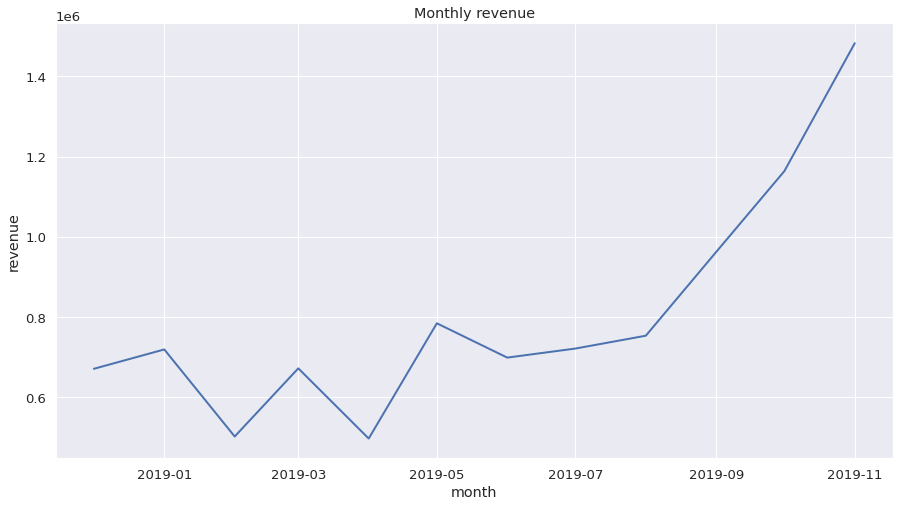

In [69]:
# plotting a line graph of monthly revenue
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=month_rev, x="InvMonth", y="ItemTotal", linewidth=2)
plt.title('Monthly revenue')
plt.xlabel('month')
plt.ylabel('revenue');

Monthly revenue graph very much resembles the monthly orders graph.

There is a noticeable upward trend that shows overall growth in revenue from December 2018 to November 2019.

Lowest months were February and April 2019.

From August / September the revenue is noticeably increasing, continuing with a huge spike in revenue in November 2019 and this upward trend probably is connected to the Holiday season.

In [70]:
# grouping items by Stock Code and calculating revenue for each
item_rev = df_new.groupby('StockCode')['ItemTotal'].sum().reset_index()

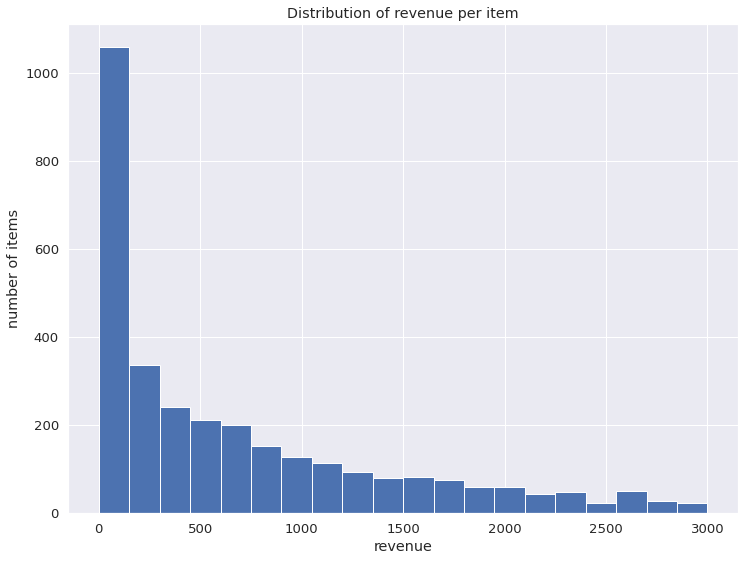

In [71]:
# plotting distribution of revenue per stock code
item_rev['ItemTotal'].plot(kind='hist',
        bins=20,
        title='Distribution of revenue per item',
        figsize=(12,9),
        range=(0,3000))
plt.xlabel('revenue')
plt.ylabel('number of items');

In [72]:
# checking statistics of revenue per item
item_rev['ItemTotal'].describe()

count      3871.000000
mean       2485.241635
std        6317.311814
min           0.000000
25%         124.330000
50%         663.150000
75%        2124.415000
max      165414.750000
Name: ItemTotal, dtype: float64

In [73]:
# exploring percentiles
np.percentile(item_rev['ItemTotal'], [90, 95, 99])

array([ 6252.65 , 10936.92 , 25557.331])

On average revenue per item is 2485. Usually items would generate between 124 - 2124 in revenue.
Only few items, 5%, exceed 10936 in revenue.

In [74]:
# finding outliers in item revenue
mean_rev = item_rev['ItemTotal'].mean()
median_rev = item_rev['ItemTotal'].median()
std_rev = item_rev['ItemTotal'].std()
rev_outliers = item_rev[item_rev['ItemTotal'] > (mean_rev + 2 * std_rev)]
rev_outliers.sort_values(by='ItemTotal', ascending=False).head(10)

,StockCode,ItemTotal
1293,22423,165414.75
3372,85123A,100641.99
2641,47566,98828.59
3352,85099B,92101.20
2001,23166,81492.97
1923,23084,59266.78
990,22086,58273.25
3159,84879,56524.73
1367,22502,51095.67
2814,79321,51028.95


In [75]:
len(rev_outliers)

122

There are 122 items who could be considered as outliers when it comes to revenue they've generated.
These items have done very well in sales.

In [76]:
# grouping items by descriptions and summing item total for each item
top_by_rev = df_new.groupby(['Description']).agg({'ItemTotal':'sum'}).sort_values(by='ItemTotal', ascending=False).reset_index()
top_by_rev.head(10)

,Description,ItemTotal
0,REGENCY CAKESTAND 3 TIER,165414.75
1,WHITE HANGING HEART T-LIGHT HOLDER,102435.35
2,PARTY BUNTING,98828.59
3,JUMBO BAG RED RETROSPOT,92101.20
4,MEDIUM CERAMIC TOP STORAGE JAR,81492.97
5,RABBIT NIGHT LIGHT,59266.78
6,PAPER CHAIN KIT 50'S CHRISTMAS,58273.25
7,ASSORTED COLOUR BIRD ORNAMENT,56524.73
8,CHILLI LIGHTS,51028.95
9,JUMBO BAG PINK POLKADOT,41982.52


In [77]:
# adding cumulative revenue column to the top_by_rev df
top_by_rev['ItemTotalCum'] = top_by_rev['ItemTotal'].cumsum()
# adding cumulative revenue in percentage column
top_by_rev['ItemTotalCumPercent'] = (top_by_rev['ItemTotal'].cumsum() / top_by_rev['ItemTotal'].sum()).round(4) * 100
top_by_rev.head()

,Description,ItemTotal,ItemTotalCum,ItemTotalCumPercent
0,REGENCY CAKESTAND 3 TIER,165414.75,165414.75,1.72
1,WHITE HANGING HEART T-LIGHT HOLDER,102435.35,267850.10,2.78
2,PARTY BUNTING,98828.59,366678.69,3.81
3,JUMBO BAG RED RETROSPOT,92101.20,458779.89,4.77
4,MEDIUM CERAMIC TOP STORAGE JAR,81492.97,540272.86,5.62


In [78]:
# checking total revenue
top_by_rev['ItemTotalCum'].max()

9620370.370000007

In [99]:
df['rev']=df['Quantity']*df['UnitPrice']
df['rev'].sum()

9747747.933999998

### Items

In [79]:
# grouping df by stock code and description
# counting the amount of unique months for each item + counting how many times an item was ordered
monthly_items = df_new.groupby(['StockCode', 'Description']).agg({'InvMonth':'nunique','StockCode':'count'})
monthly_items.columns = ['Month_Count', 'Item_Count']
monthly_items = monthly_items.reset_index()
top_items = monthly_items.sort_values(by='Item_Count', ascending=False)
top_items.head(10)
top10items = top_items.head(10)

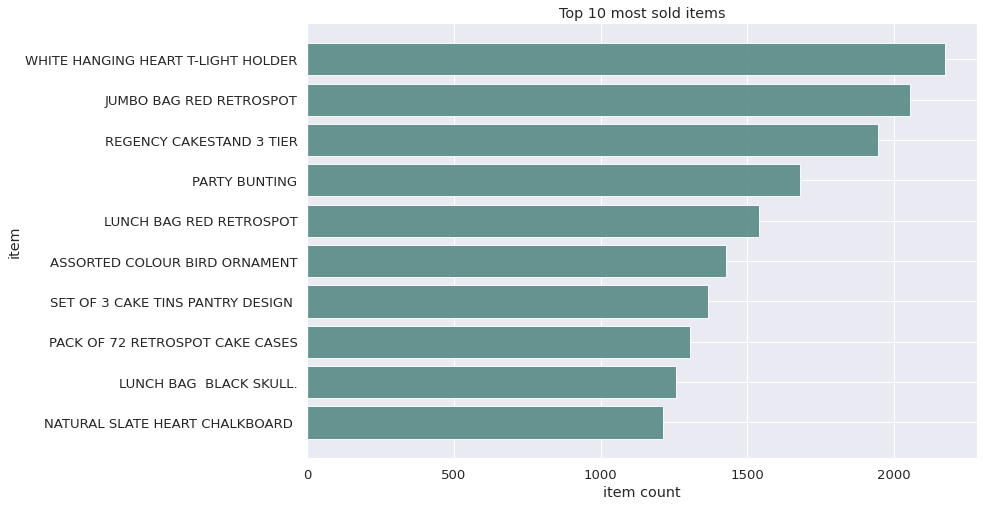

In [80]:
# plotting a bar graph with most popular items
plt.figure(figsize=(12,8))
y= top10items['Description']
x= top10items['Item_Count']
plt.barh(y, x, color='#558a86', alpha=0.9)
plt.gca().invert_yaxis()
plt.ylabel("item")
plt.xlabel("item count") 
plt.title("Top 10 most sold items")
plt.show()

These are the top 10 selling items that have been purchased all year round.

In [81]:
# looking at number of items per invoice by
# grouping the df by customer ID and invoice number
# counting stock codes in each invoice
item_qty = df_new[['CustomerID', 'InvoiceNo','StockCode']].groupby(['CustomerID','InvoiceNo']).count().reset_index()
item_qty.tail()

,CustomerID,InvoiceNo,StockCode
18915,18283,578262,102
18916,18283,579673,50
18917,18287,554065,29
18918,18287,570715,38
18919,18287,573167,3


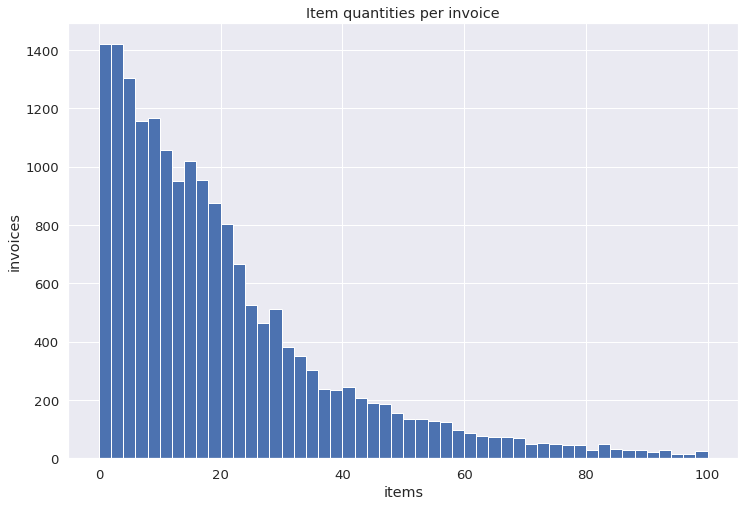

In [82]:
# plotting item quantities per invoice histogram
item_qty['StockCode'].plot(kind='hist',
        bins=50,
        title='Item quantities per invoice',
        figsize=(12,8),
        range=(0,100))
plt.xlabel('items')
plt.ylabel('invoices');

In [83]:
# looking at statistics of items per invoice
item_qty.StockCode.describe()

count    18920.000000
mean        26.267072
std         45.639457
min          1.000000
25%          6.750000
50%         15.000000
75%         29.000000
max       1107.000000
Name: StockCode, dtype: float64

In [84]:
# exploring percentiles
np.percentile(item_qty.StockCode, [90, 95, 99])

array([ 53.,  77., 216.])

On average, there are 26 items in one order. 
The majority of orders (50%) have 15 items or fewer, while 75% have 29 items or fewer.
Only a small percentage of orders (10%) exceed 53 items.

In [85]:
# finding outliers in items per invoice
mean_qty = item_qty['StockCode'].mean()
median_qty = item_qty['StockCode'].median()
std_qty = item_qty['StockCode'].std()
qty_outliers = item_qty[item_qty['StockCode'] > (mean_qty + 2 * std_qty)]
qty_outliers.sort_values(by='StockCode', ascending=False)
len(qty_outliers)

529

### Item categorization

In [86]:
# removing extra spaces from the descriptions
df_new['Description'] = (
    df_new['Description']
#     .replace(r'[0-9]+', '', regex=True)
    .replace(r'\s+', ' ', regex=True)
    .str.strip()
)

In [87]:
# creating item categories based on keywords in the 'Description' column:
categories = [
    ['toys & games', 'GLIDERS'],
    ['kitchen', 'CAKE CASES'],
    ['festive', 'CHRISTMAS', 'XMAS', 'SNOW', 'EASTER', 'SPINNING TOPS', 'WREATH', 'BELLS', 'GARLAND', 'ADVENT', 'JINGLE BELL'],
    ['home & decor',
        'DECORATION', 'BOX', 'TRINKET POT', 'CASE', 'FRAME', 'SIGN', 'DESIGN', 'TIN', 'CONTAINER',
        'TOWELS', 'THROW', 'PARASOL', 'UMBRELLA', 'DOORMAT', 'MAT', 'DOOR', 'HANGER', 'HOOK',
        'WALL', 'BLOCK WORD', 'WICKER', 'TISSUE', 'DOILIES', 'DRAWER', 'CABINET', 'CLOCK', 'RACK',
        'CUSHION', 'PHOTO', 'BOTTLE', 'HOME',
    ],
    ['candles & lighting', 'T-LIGHT', 'CANDLE', 'LANTERN', 'LAMP', 'LIGHT'],
    ['accessories', 'BAG', 'BACKPACK', 'RUCKSACK', 'SHOPPER', 'SACK', 'HAT', 'PONCHO', 'HAND WARMER'],
    ['stationery & crafts',
        'STATIONERY', 'PENCIL', 'PEN', 'CARD', 'NOTES', 'NOTEBOOK', 'PAD', 'STICKERS', 'OFFICE',
        'SEWING', 'CRAFT', 'KIT', 'CRAYONS', 'PAINT SET', 'BOOK', 'DRAWING', 'RULER', 'ERASER', 'STAMP', 'TAPE',
        'CANVAS', 'CALCULATOR', 'ENVELOPE', 'MAGNETS',
         
    ],
    ['party',
        'PARTY', 'RIBBON', 'PAPER CHAIN', 'BUNTING', 'WRAP', 'CAKE', 'GIFT', 'BALLOON', 'POPCORN',
        'ORNAMENT',
    ],
    ['kitchen',
        'TRAY', 'PLATE', 'CUP', 'KITCHEN', 'JAM', 'CAKESTAND', 'GLASS', 'BOWL', 'MUG', 'CAKE CASES',
        'BREAKFAST', 'PAN', 'CHOPPING BOARD', 'CUTLERY', 'KNIFE', 'SPOON', 'FORK', 'TEA',
        'COOKIE CUTTER', 'BAKING', 'NAPKIN', 'OVEN', 'COASTERS', 'JUG', 'CERAMIC', 'DISH', 'BREAD', 'EGG', 'BISCUIT',
        'BEAKER', 'MARKET', 'TONGS', 'APRON', 'WASHING UP',
    ],
    ['jewelry', 'JEWEL', 'NECKLACE', 'RING', 'FILIGREE'],
    ['toys & games',
        'TOY', 'JIGSAW', 'DOMINOES', 'PLAYHOUSE', 'CHALK', 'BLACK BOARD', 'BLACKBOARD' 'DOLL',
        'GAME', 'ROUNDERS', 'NAUGHTS', 'BINGO', 'TEDDY',
    ],
    ['plants & garden',
         'GARDEN', 'TRELLIS', 'HERB MARKER', 'SECATEURS', 'PLANT', 'LADDER'
        
    ]
]

# defining a function to categorize items based on the provided categories and keywords
def categorize(row):
    for c in categories:
        category, keywords = c[0], c[1:]
        for keyword in keywords:
            if keyword in row:
                return category

    return 'others'

# applying the categorization function to create a new 'Category' column in the dataset
df_new['Category'] = df_new['Description'].apply(categorize)

# identifying uncategorized items
uncategorized = df_new[df_new['Category']=='others']

# calculating and displaying the ratio of uncategorized items to the total number of items
print(f"{uncategorized.size} / {df_new.size} | {uncategorized.size / df_new.size}")
# displaying the number of unique uncategorized items
print(uncategorized['Description'].drop_duplicates().size)
uncategorized['Description'].drop_duplicates().tail(50)


# extracting remaining phrases from uncategorized items and analyzing the most common ones

remaining = [
    phrase
    for description in uncategorized['Description']
    for phrase in TextBlob(description).noun_phrases
]

remaining

# displaying the most common remaining phrases and their frequencies
Counter(remaining).most_common(50)


541890 / 7454595 | 0.07269207783923876
659


[('set of', 945),
 ('clothes pegs retrospot pack', 746),
 ('pack of', 636),
 ('assorted colours silk fan', 510),
 ('cream sweetheart mini chest', 509),
 ('toast its', 465),
 ('traditional wooden skipping rope', 403),
 ('red woolly hottie white heart', 383),
 ('traditional modelling clay', 372),
 ('painted metal pears assorted', 370),
 ('key fob', 362),
 ('shed', 362),
 ('doughnut lip gloss', 326),
 ('piggy bank retrospot', 323),
 ('hanging owls ollie beak', 305),
 ('number tile vintage font', 280),
 ('ice cream sundae lip gloss', 269),
 ('small hanging ivory/red wood bird', 248),
 ('scottie dogs baby bib', 239),
 ('glitter butterfly clips', 238),
 ('small red retrospot windmill', 228),
 ('hanging heart with bell', 227),
 ('sandcastle flags assorted', 224),
 ('dolly pegs retrospot', 217),
 ('strawberry bath sponge', 215),
 ('apple bath sponge', 214),
 ('filigris heart with butterfly', 212),
 ('vintage union jack memoboard', 211),
 ('holiday fun ludo', 210),
 ('large circular mirror mobi

7% of all entries remain uncategorized or - categorized as 'others'

In [88]:
# looking at the new category column
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvYear,InvMonth,InvWeek,InvDay,InvCount,ItemTotal,InvTotal,Category
0,536847,22155,STAR DECORATION RUSTIC,48,2018-12-01 09:31:00,0.42,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,20.16,215.58,home & decor
1,536847,21807,WHITE CHRISTMAS STAR DECORATION,36,2018-12-01 09:31:00,0.42,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.12,215.58,festive
2,536847,22161,HEART DECORATION RUSTIC HANGING,24,2018-12-01 09:31:00,0.65,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.60,215.58,home & decor
3,536847,22065,CHRISTMAS PUDDING TRINKET POT,24,2018-12-01 09:31:00,1.45,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,34.80,215.58,festive
4,536847,20956,PORCELAIN T-LIGHT HOLDERS ASSORTED,12,2018-12-01 09:31:00,1.25,17135,2018,2018-12-01,2018-11-26,2018-12-01,7,15.00,215.58,candles & lighting


In [89]:
# grouping df by category and description, and counting unique items in the categories
items_cat = df_new.groupby(['Category'])['Description'].nunique().reset_index().sort_values(by='Description',ascending=False)
items_cat.columns = ['Category', 'Amount']
items_cat

,Category,Amount
3,home & decor,1147
6,others,659
5,kitchen,518
9,stationery & crafts,382
1,candles & lighting,299
2,festive,295
4,jewelry,218
0,accessories,181
7,party,157
8,plants & garden,50


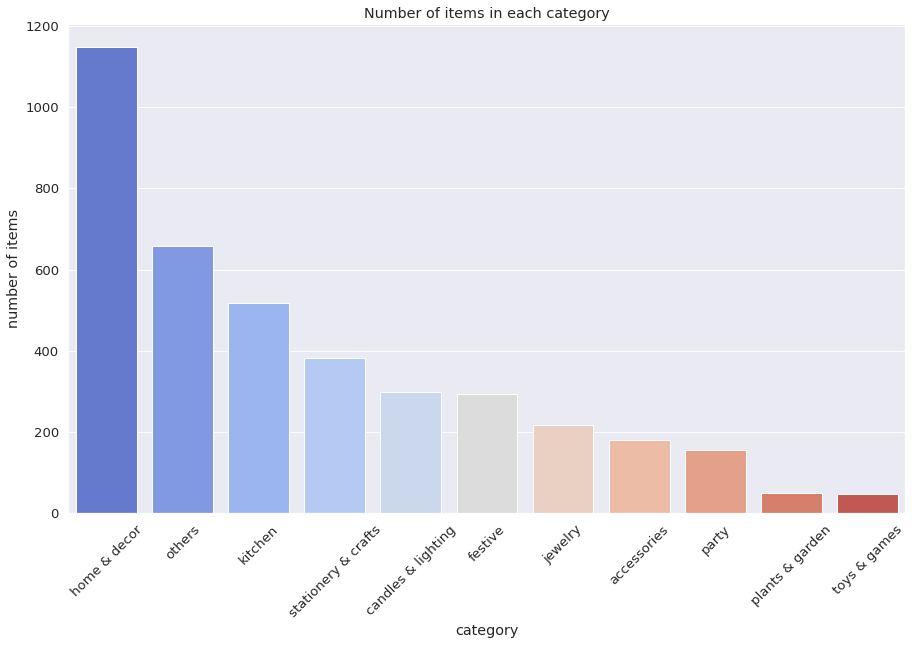

In [90]:
# plotting a graph of number of items in each category
sns.set(font_scale=1.2)
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Category", y='Amount', data=items_cat, palette='coolwarm')
plt.title('Number of items in each category')
plt.xlabel('category')
plt.ylabel('number of items')
plt.xticks(rotation = 45);

It appears most of the items fell into and could be described as home & decor.
The uncategorized ones make up approx. half less than in home & decor category.
Kitchen appears to be a big category as well.
Least items are in plants & garden and toys & games.

In [91]:
# grouping df by category and counting the number of entries in each category
items_in_df = df_new.groupby(['Category']).count().reset_index()[['Category', 'InvoiceNo']].sort_values(by='InvoiceNo',ascending=False)
items_in_df.columns = ['Category', 'Amount']
items_in_df

,Category,Amount
3,home & decor,189394
5,kitchen,70719
9,stationery & crafts,51683
0,accessories,43093
6,others,36126
2,festive,32117
1,candles & lighting,30001
7,party,21747
10,toys & games,9920
4,jewelry,6144


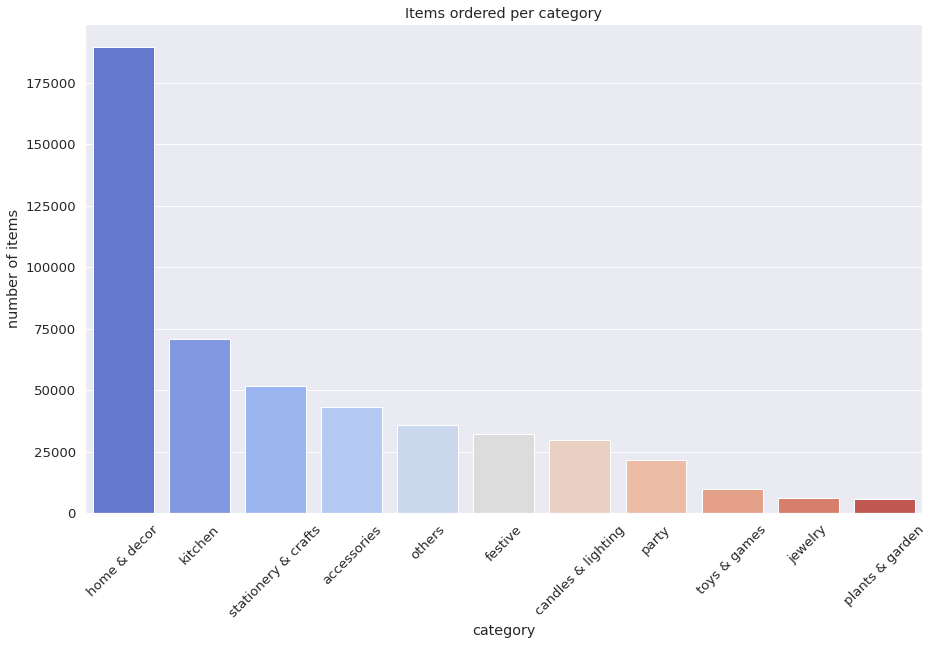

In [92]:
# plotting a graph of number of items ordered in each category
plt.figure(figsize=(15, 9))
ax = sns.barplot(x="Category", y='Amount', data=items_in_df, palette='coolwarm')
plt.title('Items ordered per category')
plt.xlabel('category')
plt.ylabel('number of items')
plt.xticks(rotation = 45);

Most ordered items are from home & decor, kitchen and stationery & crafts categories.
Jewelery and plants & gardens items have been ordered the least.

In [93]:
# grouping df by category and month and calculating revenue in each category for every month
categories_rev = df_new.groupby(['Category', 'InvMonth']).agg({'ItemTotal':'sum'})

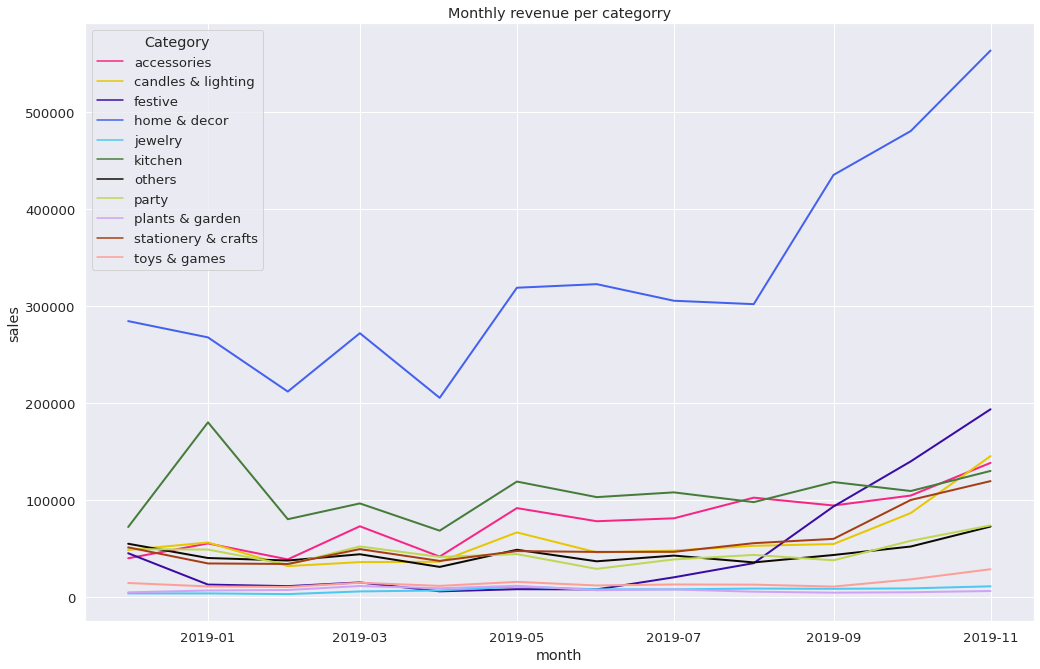

In [94]:
# plotting a line graph of monthly revenue per category
palette = ["#F72585", "#e6c700", "#3A0CA3", "#4361EE", "#4CC9F0", "#457c39", 
           "#0f0a01", "#BED754", "#D0A2F7", "#a63e14", "#fe9f97"]
plt.figure(figsize=(17,11))
sns.set(font_scale=1.2)
ax = sns.lineplot(data=categories_rev, x="InvMonth", y="ItemTotal",hue="Category", linewidth=2, palette = palette)
plt.title('Monthly revenue per categorry')
plt.xlabel('month')
plt.ylabel('sales');

In [95]:
# grouping df by description and category, summing up quntity of item sold
item_qty_cat = df_new.groupby(['Description', 'Category'])['Quantity'].sum().sort_values(ascending=False).reset_index()
item_qty_cat.head(10)

,Description,Category,Quantity
0,MEDIUM CERAMIC TOP STORAGE JAR,kitchen,77856
1,WORLD WAR 2 GLIDERS ASSTD DESIGNS,toys & games,50614
2,JUMBO BAG RED RETROSPOT,accessories,47308
3,WHITE HANGING HEART T-LIGHT HOLDER,candles & lighting,36493
4,PACK OF 72 RETROSPOT CAKE CASES,kitchen,35382
5,ASSORTED COLOUR BIRD ORNAMENT,party,34897
6,POPCORN HOLDER,party,32180
7,RABBIT NIGHT LIGHT,candles & lighting,27349
8,MINI PAINT SET VINTAGE,stationery & crafts,26017
9,PACK OF 12 LONDON TISSUES,home & decor,25102


These are the top 10 items by quantity of item sold (quantity added to cart).

## Hypothesis testing 

H0: there is no significant difference in revenue for item category accross different months

H1: there is a significant difference in revenue for item category accross different months

In [96]:
# filtering out rows where ItemTotal exceeds 0
df_test = df_new.query('ItemTotal > 0')

In [97]:
# iterating through each item category 
# and conducting a one-way ANOVA test for item total revenue across different months

for category, data in df_test.groupby('Category'):
    anova_result = stats.f_oneway(*[month_data['ItemTotal'] for month, month_data in data.groupby('InvMonth')])
    print(f"Category: {category}, F-statistic: {anova_result.statistic:.5f}, P-value: {anova_result.pvalue:.5f}")
    
    alpha = 0.05
    
    if (anova_result.pvalue < alpha):
        print("Reject the null hypothesis. There is a significant difference in revenue for category accross different months.")
    else:
        print("Fail to reject the null hypothesis. There is no significant difference in revenue for category accross different months.")
    print('-----------------------------')

Category: accessories, F-statistic: 8.98269, P-value: 0.00000
Reject the null hypothesis. There is a significant difference in revenue for category accross different months.
-----------------------------
Category: candles & lighting, F-statistic: 1.98554, P-value: 0.02567
Reject the null hypothesis. There is a significant difference in revenue for category accross different months.
-----------------------------
Category: festive, F-statistic: 7.94779, P-value: 0.00000
Reject the null hypothesis. There is a significant difference in revenue for category accross different months.
-----------------------------
Category: home & decor, F-statistic: 3.52025, P-value: 0.00006
Reject the null hypothesis. There is a significant difference in revenue for category accross different months.
-----------------------------
Category: jewelry, F-statistic: 7.67675, P-value: 0.00000
Reject the null hypothesis. There is a significant difference in revenue for category accross different months.
----------

It appears for most categories the revenue across different months do differ, except, revenue in kitchen and toys & games categories have not been statistically different across months. 

## General conlusion

### Data preparation

There are 1454 rows that are missing item descriptions, unit prices and customer IDs. Each of these invoices appear in the whole dataset only once and make up 0.26 % of the data. These rows were excluded from the analysis.

Approx. 1% of the data consists of duplicates (5268 rows). Duplicates have been recorded every month from Nov. 2018 until Dec. 2019.

3836 entries were for cancelled / discount applied items. These rows were removed from the analysis along with the 'bad debt' entries. In addition, entries with lowercase descriptions that amount for lost / damaged goods were excluded as well, and lastly, Amazon and postage fee rows were not included in the further analysis too.

Since the data covers only 2 days in November 2018 and a week of December 2019, these 2 incomplete months were excluded from the analysis.

### EDA
__Orders__

From December 2018 to April 2019, there are noticeable fluctuations in the number of orders, however, the most prominent observation is a significant spike in the number of orders in May 2019.

In the following months the invoice count is lower, but still higher than during the beginning of the year. Around September 2019 there's a noticeable spike again that lasts until the end of the year. Highest amount of orders have been made in October and November 2019 which might be due to the upcoming Holiday season and Black Friday.

On average, between 29th of Nov. 2018 and 7th of Dec. 2019, customers have placed 4 orders. In 50% of cases customers have placed 1 to 4 orders.

Not more than 10% of customers have placed more than 9 orders. Not more than 5% of customers have placed 13 or more orders.

__Revenue__

Monthly revenue graph very much resembles the monthly orders graph.

There is a noticeable upward trend that shows overall growth in revenue from December 2018 to November 2019.

Lowest months were February and April 2019.

From August / September the revenue is noticeably increasing, continuing with a huge spike in revenue in November 2019 and this upward trend probably is connected to the Holiday season.

On average revenue per item is 2485. Usually items would generate between 124 - 2124 in revenue. Only few items, 5%, exceed 10936 in revenue.


__Items and categories__

On average, there are 26 items in one order. The majority of orders (50%) have 15 items or fewer, while 75% have 29 items or fewer. Only a small percentage of orders (10%) exceed 53 items.

After categorizing items, it appears most of the items could be described and categorized as home & decor. The uncategorized ones make up approx. half less than in home & decor category. Kitchen appears to be a big category as well. Least items are in plants & garden and toys & games.

Most ordered items are from home & decor, kitchen and stationery & crafts categories. Jewelery and plants & garden items have been ordered the least.


### Hypothesis testing

The results of the one-way ANOVA test indicate a statistically significant difference in item category revenues across different months. However, the revenues in the kitchen and toys & games categories did not reveal statistically significant differences across months.

### Recommendations

Prioritizing resources and marketing efforts on the most selling item categories, particularly, home & decor and kitchen.

Evaluating least performing categories such as jewelery and plants & garden, possibly exploring opportunities to diversify the product range.

Enhancing item descriptions to provide clarity and attract customers.

Ensuring proper data collection - investigating the cause of duplicates and other possible issues in data collection and quality.